In [2]:
import pandas as pd
import numpy as np
dirty_data_priora = pd.read_csv('C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_List1.csv')

# подготавливаем цифровые данные
priora_only_input = dirty_data_priora[['дата', 'часы в пути', 'минуты в пути', 'пробег', 'средний расход', 
                                       'температура', 'маршрут', 'топливо', 'откуда', 'до куда']]
priora_num = priora_only_input.rename(columns={'часы в пути': 'hours', 'маршрут': 'km', 'минуты в пути':'minutes'})
priora_num['temperature'] = pd.to_numeric(priora_num['температура'].str.replace(',','.'), errors='coerce')
priora_num['path'] = pd.to_numeric(priora_num['km'].str.replace(',','.'), errors='coerce')
priora_num['hrs'] = priora_num.hours + priora_num.minutes/60
priora_num['fuel'] = pd.to_numeric(priora_num['топливо'].str.replace(',','.'), errors='coerce')
priora_num['time_h'] = np.diff(priora_num.hrs, prepend=0)
priora_num['benz'] = np.diff(priora_num.fuel, prepend=0)
priora_num['distance'] = np.diff(priora_num.path, prepend=0)
priora_num['av_speed'] = priora_num.distance / priora_num.time_h
priora_num['rashod'] = 100 * priora_num.benz / priora_num.distance

priora_num.drop(columns=['откуда', 'до куда']).head()

# отфильтровываем неразумные данные и исключаем нечисловые (вспомогательные информационные) колонки
priora_detailsfree = priora_num[['temperature', 'distance', 'time_h', 'benz', 'av_speed', 'rashod']] \
                    .query('distance > 3 & time_h > 0 & rashod < 50')
priora_detailsfree.head()

,temperature,distance,time_h,benz,av_speed,rashod
2,2.0,32.8,0.633333,2.8,51.789474,8.536585
4,1.0,35.6,0.666667,2.3,53.400000,6.460674
5,24.0,366.2,16.066667,37.2,22.792531,10.158383
6,24.0,5.3,0.083333,0.4,63.600000,7.547170
7,24.0,66.2,1.283333,4.8,51.584416,7.250755


In [3]:
# высчитываем глобальные величины по всей базе
global_sr_ras = 100 * priora_detailsfree.benz.sum() / priora_detailsfree.distance.sum()
global_sr_skor = priora_detailsfree.distance.sum() / priora_detailsfree.time_h.sum()
print(
        'средняя скорось за все время эксплуатации = ', round(global_sr_skor, 2),
        'км/ч, при среднем расходе', round(global_sr_ras, 2), 'л/100км'
     )

средняя скорось за все время эксплуатации =  24.76 км/ч, при среднем расходе 9.82 л/100км


<AxesSubplot:xlabel='time_h', ylabel='benz'>

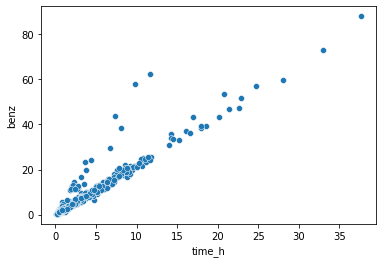

In [4]:
# возьмем бензин в заивсимости от времени. Видно, что основная часть точек подчиняется линейному закону benz = 2*time_h
# Но есть другая ветвь с законом benz = 6*time_h
import seaborn as sns
sns.scatterplot(data=priora_detailsfree, x='time_h', y='benz')

In [5]:
# Возьмеме за разделительную черту benz = 4*time_h
priora_detailsfree['benz_threshold'] = 4*priora_detailsfree.time_h
priora_detailsfree.head()

,temperature,distance,time_h,benz,av_speed,rashod,benz_threshold
2,2.0,32.8,0.633333,2.8,51.789474,8.536585,2.533333
4,1.0,35.6,0.666667,2.3,53.400000,6.460674,2.666667
5,24.0,366.2,16.066667,37.2,22.792531,10.158383,64.266667
6,24.0,5.3,0.083333,0.4,63.600000,7.547170,0.333333
7,24.0,66.2,1.283333,4.8,51.584416,7.250755,5.133333


In [6]:
# дадим классификацию normal/anomalous
priora_detailsfree.loc[priora_detailsfree['benz'] <= priora_detailsfree['benz_threshold'], 'check'] = 'normal' 
priora_detailsfree.loc[priora_detailsfree['benz'] > priora_detailsfree['benz_threshold'], 'check'] = 'anomalous'
priora_detailsfree

normal_data = priora_detailsfree.query('check == "normal"')
anomalous_data = priora_detailsfree.query('check == "anomalous"')

<AxesSubplot:xlabel='time_h', ylabel='benz'>

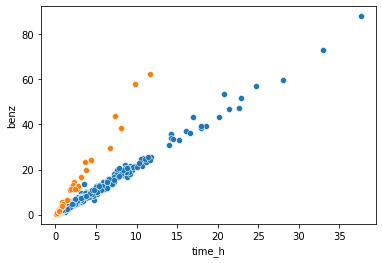

In [7]:
sns.scatterplot(data=normal_data, x='time_h', y='benz')
sns.scatterplot(data=anomalous_data, x='time_h', y='benz')

<AxesSubplot:xlabel='av_speed', ylabel='rashod'>

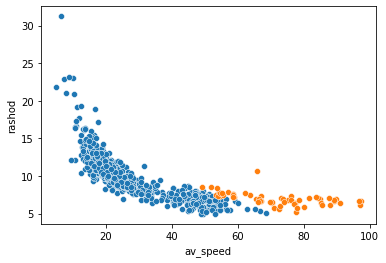

In [8]:
sns.scatterplot(x='av_speed', y='rashod', data=normal_data)
sns.scatterplot(x='av_speed', y='rashod', data=anomalous_data)

In [9]:
# большие траты бензина в единицу времени происходят в поездках при большой скорости.

In [10]:
#распределение по скоростям бимодальное
first_mode = priora_detailsfree.loc[(priora_detailsfree['av_speed'] < 40)]
second_mode = priora_detailsfree.loc[(priora_detailsfree['av_speed'] > 40) & (priora_detailsfree['av_speed'] < 60)]
# можно выделить также третью моду
third_mode = priora_detailsfree.loc[(priora_detailsfree['av_speed'] > 60)]

In [11]:
# смотрим какие поездки составляют вторую моду
list_sm = second_mode.index
second_mode_dirty = priora_num.loc[priora_num.index.isin(list_sm)]
second_mode_dirty[['дата', 'откуда', 'до куда']].head()

,дата,откуда,до куда
2,03.05.2016,город,"Мана, сосна"
4,03.05.2016,"Мана, трасса",город
7,14.05.2016,на Ману,с Маны
14,23.05.2016,город,дача
15,23.05.2016,дача,город


In [12]:
# смотрим какие поездки составляют третью моду
list_sm = third_mode.index
third_mode_dirty = priora_num.loc[priora_num.index.isin(list_sm)]
third_mode_dirty[['дата', 'откуда', 'до куда']].head(5)

,дата,откуда,до куда
6,14.05.2016,город,город
19,24.05.2016,город,аэропорт
27,01.06.2016,город,город
32,04.06.2016,город,ТаМожня
54,21.06.2016,Красноярск,Агинское


In [14]:
# большинство поездок по городу (первая мода), в пригороде (вторая мода), и поездки по трассе или пустому городу (третья мода)
print('средняя скорость по городу =', round(first_mode.av_speed.mean(), 1), 
      'км/ч, в пригороде -', round(second_mode.av_speed.mean(), 1), 
      'км/ч, по трассе -', round(third_mode.av_speed.mean(), 1), 'км/ч'
     )

средняя скорость по городу = 21.5 км/ч, в пригороде - 49.4 км/ч, по трассе - 76.7 км/ч
